In [6]:
import os, time, torch, numpy as np
from torch.utils.tensorboard.writer import SummaryWriter
from src.TorchDSP.dataloader import MyDataset 
from src.TorchDSP.eq import eqAMPBC, eqPBC, eqBiLSTM, eqCNNBiLSTM, eqID, Test, write_log
from src.TorchDSP.pbc import AmFoPBC, TorchSignal, TorchTime
from src.TorchDSP.loss import MSE, Qsq, BER_well
from src.TorchSimulation.receiver import BER



window_size = 41
Nwindow = 400000
train_data = MyDataset('dataset_A800/train.h5', Nch=[3], Rs=[40], Pch=[2], Nmodes=1,
                       window_size=window_size, strides=1, Nwindow=Nwindow, truncate=20000, 
                       Tx_window=False, pre_transform='Rx_CDCDDLMS(taps=32,lr=[0.015625, 0.0078125])')

test_data = MyDataset('dataset_A800/test.h5', Nch=[3], Rs=[40], Pch=[2], Nmodes=1,
                       window_size=window_size, strides=1, Nwindow=20000, truncate=20000, 
                       Tx_window=False, pre_transform='Rx_CDCDDLMS(taps=32,lr=[0.015625, 0.0078125])')

test_loader = torch.utils.data.DataLoader(test_data, batch_size=10000, shuffle=True, drop_last=True)

print('Train Data number:',len(train_data))
print('Test Data number:',len(test_data))
    

# id_net = eqID(M=window_size)
# Test(id_net, test_loader)

Train Data number: 79930
Test Data number: 20000


## 1. eqAMPBC + BFGS

In [3]:
log_path = '_outputs/log_test/AMPBC_MSE_LBFGS'
os.makedirs(log_path, exist_ok=True)
writer = SummaryWriter(log_path)
epochs = 10

train_loader = torch.utils.data.DataLoader(train_data, batch_size=Nwindow, shuffle=True, drop_last=True)
data_iter = iter(train_loader)
Rx,Tx,info = next(data_iter)
Rx, Tx, info = Rx.cuda(), Tx.cuda(), info.cuda()

net = eqAMPBC(M=window_size, rho=1, fwm_share=True)
# net = eqPBC(M=window_size, rho=1, index_type='reduce-2', pol_share=True)
# net = eqCNNBiLSTM(M=window_size, channels=64, kernel_size=11, hidden_size=40)
net.cuda()
optimizer = torch.optim.LBFGS(net.parameters(), lr=1)

def closure():
    optimizer.zero_grad()
    PBC = net(Rx, info)
    loss = MSE(PBC, Tx)
    loss.backward()
    return loss


for epoch in range(epochs):
    t0 = time.time()
    loss = optimizer.step(closure)
    t1 = time.time() 
    print('Time per epoch: ', t1 - t0, flush=True)
    write_log(writer, epoch, loss.item(), Test(net, test_loader))

Time per epoch:  0.9124948978424072
0 Train MSE: 0.051195766776800156 Test MSE: 0.04455765523016453 Qsq: 6.9939935164127895
Time per epoch:  0.5845835208892822
1 Train MSE: 0.04441987723112106 Test MSE: 0.0445339884608984 Qsq: 6.991024198543448
Time per epoch:  0.03559374809265137
2 Train MSE: 0.044395312666893005 Test MSE: 0.0445339921861887 Qsq: 6.991024198543448
Time per epoch:  0.03522753715515137
3 Train MSE: 0.044395312666893005 Test MSE: 0.0445339921861887 Qsq: 6.991024253813575
Time per epoch:  0.03551459312438965
4 Train MSE: 0.044395312666893005 Test MSE: 0.0445339884608984 Qsq: 6.991024253813575
Time per epoch:  0.03570437431335449
5 Train MSE: 0.044395312666893005 Test MSE: 0.04453398659825325 Qsq: 6.991024143273322
Time per epoch:  0.035602569580078125
6 Train MSE: 0.044395312666893005 Test MSE: 0.04453399032354355 Qsq: 6.991024253813575
Time per epoch:  0.03465676307678223
7 Train MSE: 0.044395312666893005 Test MSE: 0.0445339884608984 Qsq: 6.991024253813575
Time per epoch

## 2. eqAMPBC + Adam

In [14]:
log_path = '_outputs/log_test/AMPBC_MSE_Adam'
os.makedirs(log_path, exist_ok=True)
writer = SummaryWriter(log_path)
epochs = 10

train_loader = torch.utils.data.DataLoader(train_data, batch_size=10000, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=10000, shuffle=True, drop_last=True)

net = eqAMPBC(M=window_size, rho=1)
net.cuda()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

for epoch in range(epochs):
    train_loss = 0
    for i, (Rx, Tx, info) in enumerate(train_loader):
        Rx, Tx, info = Rx.cuda(), Tx.cuda(), info.cuda()
        y = net(Rx, info)
        loss = MSE(y, Tx)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()  
        writer.add_scalar('Loss/train_batch', loss.item(), epoch*len(train_loader)+i)
    scheduler.step()
    metric = Test(net, test_loader)
    write_log(writer, epoch, train_loss/len(train_loader), metric)


0 Train MSE: 0.04637221237644553 Test MSE: 0.04479070380330086 Qsq: 6.982140469774956
1 Train MSE: 0.04444045387208462 Test MSE: 0.0445682667195797 Qsq: 6.99994437954108
2 Train MSE: 0.0443572604097426 Test MSE: 0.04454744793474674 Qsq: 7.004418311650058
3 Train MSE: 0.04435195215046406 Test MSE: 0.04454072378575802 Qsq: 7.002180217010911
4 Train MSE: 0.04435531096532941 Test MSE: 0.04455026984214783 Qsq: 7.003672059815807
5 Train MSE: 0.04432940073311329 Test MSE: 0.044539330527186394 Qsq: 6.992508377183107
6 Train MSE: 0.04432278340682387 Test MSE: 0.04453166387975216 Qsq: 6.99771095947793
7 Train MSE: 0.044320307485759255 Test MSE: 0.04453342594206333 Qsq: 6.998455158475696
8 Train MSE: 0.044319847319275144 Test MSE: 0.04453243687748909 Qsq: 7.000689402108675


KeyboardInterrupt: 

array([<Axes: >, <Axes: >], dtype=object)

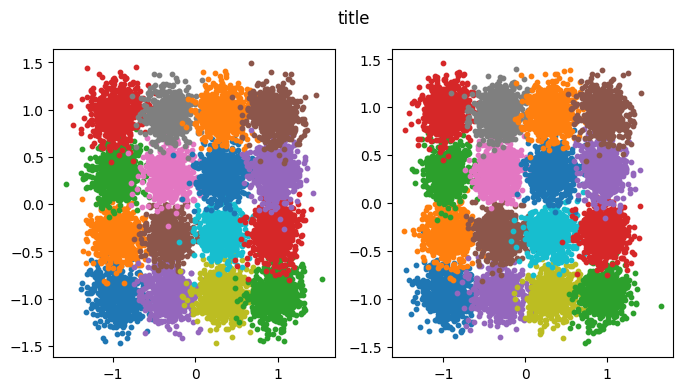

In [15]:
for Rx, Tx, info in test_loader:
    Rx, Tx, info = Rx.cuda(), Tx.cuda(), info.cuda()
    y = net(Rx, info)
    break

from src.TorchSimulation.utils import show_symb
show_symb(y, Tx)

# 3. AMPBC + NN

In [16]:
from src.TorchDSP.eq import eqAMPBCaddNN

log_path = '_outputs/log_test/AMPBC+NN_MSE_Adam'
os.makedirs(log_path, exist_ok=True)
writer = SummaryWriter(log_path)
epochs = 60

train_loader = torch.utils.data.DataLoader(train_data, batch_size=5000, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=10000, shuffle=True, drop_last=True)

net = eqAMPBCaddNN(pbc_info={'M':window_size, 'rho':1}, nn_info={'M': 41, 'channels':64, 'kernel_size':11, 'hidden_size':40})

net.cuda()
optimizer = torch.optim.Adam([{'params': net.pbc.parameters(), 'lr': 1e-4}, {'params': net.nn.parameters(), 'lr': 1e-3}])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

for epoch in range(epochs):
    train_loss = 0
    for i, (Rx, Tx, info) in enumerate(train_loader):
        Rx, Tx, info = Rx.cuda(), Tx.cuda(), info.cuda()
        y = net(Rx, info)
        loss = MSE(y, Tx)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()  
        writer.add_scalar('Loss/train_batch', loss.item(), epoch*len(train_loader)+i)
    scheduler.step()
    metric = Test(net, test_loader)
    write_log(writer, epoch, train_loss/len(train_loader), metric)


0 Train MSE: 0.04479762646369636 Test MSE: 0.04188871569931507 Qsq: 6.991024253813575
1 Train MSE: 0.041871016193181274 Test MSE: 0.04178757779300213 Qsq: 6.982879459906709
2 Train MSE: 0.04179218523204327 Test MSE: 0.04178008623421192 Qsq: 6.982140524819627
3 Train MSE: 0.04174924599938094 Test MSE: 0.041714347898960114 Qsq: 6.984358028341755
4 Train MSE: 0.04170947032980621 Test MSE: 0.04174157604575157 Qsq: 6.996223161693933
5 Train MSE: 0.04166081119328737 Test MSE: 0.04170454852283001 Qsq: 6.986577850360106
6 Train MSE: 0.04162283493205905 Test MSE: 0.041726429015398026 Qsq: 6.982140524819627
7 Train MSE: 0.04157132590189576 Test MSE: 0.04173985496163368 Qsq: 6.971086636849899
8 Train MSE: 0.04152901316992939 Test MSE: 0.04169759713113308 Qsq: 6.978449607249187
9 Train MSE: 0.04148670984432101 Test MSE: 0.041726527735590935 Qsq: 6.964481092145932
10 Train MSE: 0.041442671045660975 Test MSE: 0.0417646300047636 Qsq: 6.9777121737478325
11 Train MSE: 0.041404455760493876 Test MSE: 0.0

array([<Axes: >, <Axes: >], dtype=object)

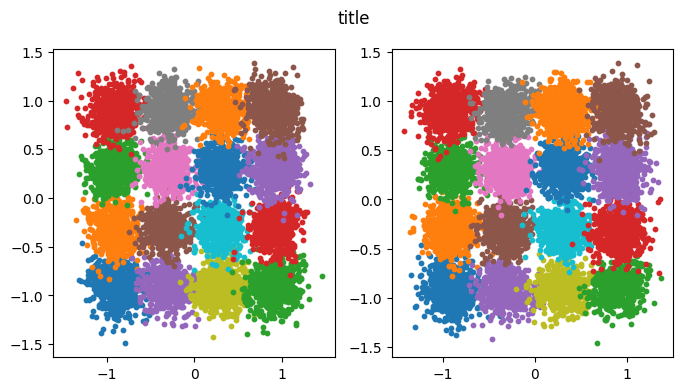

In [17]:
for Rx, Tx, info in test_loader:
    Rx, Tx, info = Rx.cuda(), Tx.cuda(), info.cuda()
    y = net(Rx, info)
    break

from src.TorchSimulation.utils import show_symb
show_symb(y, Tx)

# 4. NN

In [2]:
from src.TorchDSP.eq import eqCNNBiLSTM, eqBiLSTM, eqMLP
window_size = 41
net = eqCNNBiLSTM(M=window_size, channels=8, kernel_size=21 , hidden_size=10)

# print the number of parameters in the model
print('Number of parameters: ', sum(p.numel() for p in net.parameters() if p.requires_grad))

Number of parameters:  3960


In [25]:
from src.TorchDSP.eq import eqCNNBiLSTM, eqBiLSTM, eqMLP

log_path = '_outputs/log_test/NN_MSE_Adam'
os.makedirs(log_path, exist_ok=True)
writer = SummaryWriter(log_path)
epochs = 60

train_loader = torch.utils.data.DataLoader(train_data, batch_size=5000, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=10000, shuffle=True, drop_last=True)

net = eqCNNBiLSTM(M=window_size, channels=8, kernel_size=21 , hidden_size=10)
# net = eqBiLSTM(M=window_size, hidden_size=40)
# net = eqMLP(M=window_size)

net.cuda()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

for epoch in range(epochs):
    train_loss = 0
    for i, (Rx, Tx, info) in enumerate(train_loader):
        Rx, Tx, info = Rx.cuda(), Tx.cuda(), info.cuda()
        y = net(Rx, info)
        loss = MSE(y, Tx)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()  
        writer.add_scalar('Loss/train_batch', loss.item(), epoch*len(train_loader)+i)
    scheduler.step()
    metric = Test(net, test_loader)
    write_log(writer, epoch, train_loss/len(train_loader), metric)


0 Train MSE: 0.06093022283166647 Test MSE: 0.04994305409491062 Qsq: 6.353903117813891
1 Train MSE: 0.049708295660093424 Test MSE: 0.04921841435134411 Qsq: 6.321753499646283
2 Train MSE: 0.04917120188474655 Test MSE: 0.048786548897624016 Qsq: 6.312240338390768
3 Train MSE: 0.04895101012662053 Test MSE: 0.0486608762294054 Qsq: 6.306103031023559
4 Train MSE: 0.048886520136147735 Test MSE: 0.04861600510776043 Qsq: 6.320072120355812


KeyboardInterrupt: 

array([<Axes: >, <Axes: >], dtype=object)

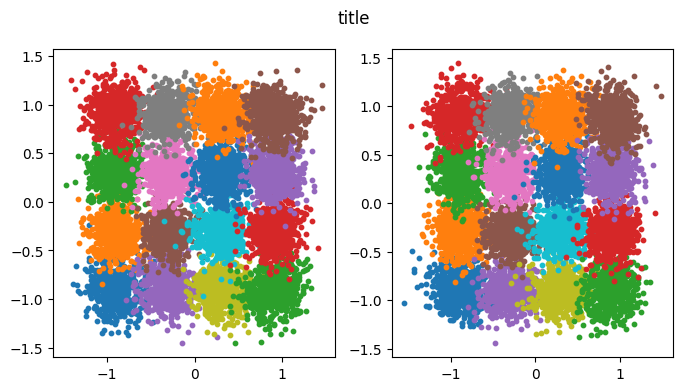

In [11]:
for Rx, Tx, info in test_loader:
    Rx, Tx, info = Rx.cuda(), Tx.cuda(), info.cuda()
    y = net(Rx, info)
    break

from src.TorchSimulation.utils import show_symb
show_symb(y, Tx)